In [1]:
%matplotlib inline

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
numpy.random.seed(7)

In [7]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [9]:
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40


In [19]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
df_test_train = df_train['count']

In [32]:
n = len(df_train_train)
train_x = df_train_train[0:int(n*.8)].astype('float32')
train_y = df_test_train[0:int(n*.8)].astype('float32')
test_x = df_train_train[int(n*.8)+1:n].astype('float32')
test_y = df_test_train[int(n*.8)+1:n].astype('float32')

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [79]:
train_x_r = scaler.fit_transform(train_x.values)
train_y_r = scaler.fit_transform(train_y.values)
test_x_r = scaler.fit_transform(test_x.values)
test_y_r = scaler.fit_transform(test_y.values)

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

In [26]:
simplernn = keras.layers.recurrent.SimpleRNN(64, init='glorot_uniform', inner_init='orthogonal', activation='sigmoid', W_regularizer=None, U_regularizer=None, b_regularizer=None, dropout_W=0.0, dropout_U=0.0)

In [138]:
model = Sequential()
#model.add(Dense(1, input_shape=(8,)))
#model.add(SimpleRNN(64, input_shape=(8,)))
#model.add(Dense(1))
#model.add(Activation('sigmoid'))

# create model
model = Sequential()
model.add(Dense(13, input_dim=8, init='normal', activation='relu'))
model.add(Dense(1, init='normal'))
# Compile model
#model.compile(loss='mean_squared_error', optimizer='adam')


model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x_r, train_y_r, nb_epoch=100, batch_size=32,verbose=1)


Exception: Error when checking model target: expected dense_54 to have shape (None, 1) but got array with shape (1, 8708)

In [81]:
trainPredict = model.predict(train_x_r)
testPredict = model.predict(test_x_r)
trainPredict = scaler.inverse_transform(trainPredict)
train_y_r = scaler.inverse_transform([train_y_r])
testPredict = scaler.inverse_transform(testPredict)
test_y_r = scaler.inverse_transform([test_y_r])

In [82]:
trainScore = math.sqrt(mean_squared_error(train_y_r[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_r[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 263.31 RMSE
Test Score: 338.55 RMSE


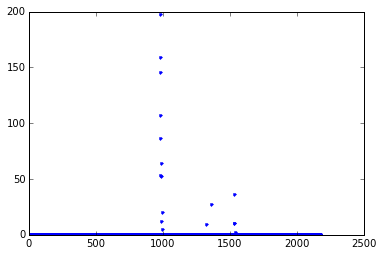

In [95]:
plt.plot(testPredict,'.')

array([ 17.44943792,  43.76853931,  34.99550551, ...,  79.95730782,
        44.86516899,  15.25617856])